# Summary

- The dataset comprises two directories: one with 7,038 photos and another with 300 Monet-style images. The first dataset needs to be converted to Monet-like pictures.
- The solution  implements the CycleGAN model with alternating updates of two generators and two discriminators.
- Key takeway: extending the training to 50 epochs resulted in more realistic and vibrant generated images. Both generator and discriminator losses decreased, confirming the model's effective convergence and successful style transfer - we can see that after each epoch the model Generator was better in creating styles.
- For the code please see final - extended.ipynb file.

# EDA

The dataset consists of two directories: one - an "input dataset" with 7,038 photos, and another named with Monet pictures with 300 images.

The photos in the latter directory need to be converted to the style of Claude Monet. Oscar-Claude Monet was a French painter and the founder of Impressionism, known for his pioneering efforts to depict nature as he perceived it, particularly through outdoor landscape painting. Despite early career challenges, he gained recognition for repeatedly painting the same scenes to capture variations in light and seasons. Notable series include haystacks, Rouen Cathedral, and his famous water lilies.


In [31]:
stats()

Number of images in Monet directory: 300
Number of images in Photo directory: 7038


In [32]:
print_image_shapes_info(MONET_PATH, 'author')
print_image_shapes_info(PHOTO_PATH, 'photo')

The number of unique image shapes in the author directory is:  1
The unique image shape sizes in the author directory include:  (256, 256, 3)
The number of unique image shapes in the photo directory is:  1
The unique image shape sizes in the photo directory include:  (256, 256, 3)


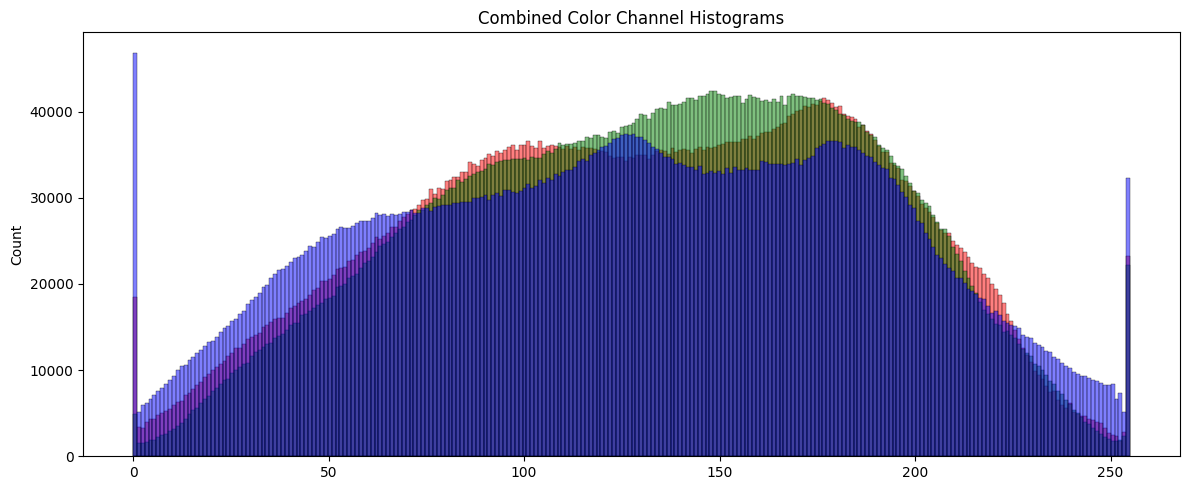

In [33]:
ImageHistogram(MONET_PATH).show_combined_histogram()

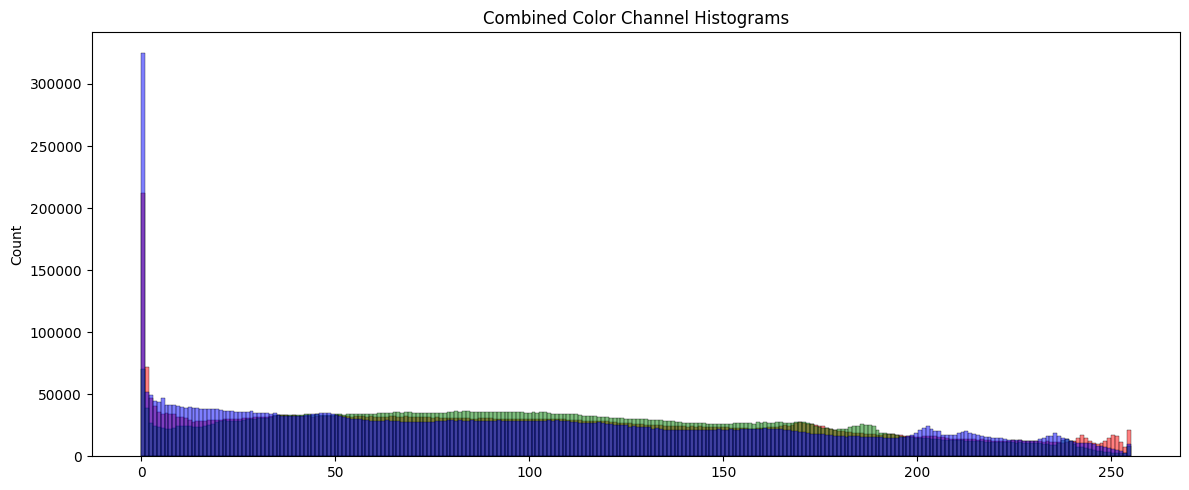

In [34]:
ImageHistogram(PHOTO_PATH).show_combined_histogram()

Key takeaway: We can see that the distribution is different for the photos compared to the Monet pictures. The first dataset is more heterogeneous.

In [3]:
from enum import Enum
import seaborn as sns
class DataType(Enum):
    TEST = "test"
    TRAIN = "train"


class CustomDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256), datatype=DataType.TEST):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.datatype = datatype
        self.transform = self._get_transform(size)
        self.monet_idx = self._create_index(self.monet_dir)
        self.photo_idx = self._create_index(self.photo_dir)

    def _get_transform(self, size):
        transform_list = [transforms.Resize(size), transforms.ToTensor()]
        
        if self.datatype == DataType.TRAIN:
            transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        
        return transforms.Compose(transform_list)

    def _create_index(self, directory):
        return {i: fl for i, fl in enumerate(glob.glob(f"{directory}/*"))}

    def __getitem__(self, idx):
        rand_idx = np.random.randint(0, len(self.photo_idx))
        photo_img = self._load_image(self.photo_dir, self.photo_idx[rand_idx])
        monet_img = self._load_image(self.monet_dir, self.monet_idx[idx])
        return photo_img, monet_img

    def _load_image(self, dir_path, file_name):
        img_path = file_name  # Since glob already gives the full path
        image = Image.open(img_path)
        return self.transform(image)
    
    def __len__(self):
        return min(len(self.monet_idx), len(self.photo_idx))

In [4]:
DATA_PATH = "data/"
BATCH_SIZE = 32 # 4
EPOCHS = 10
# DATA_PATH = # "../input/gan-getting-started"
device = "cuda:0"

In [5]:
img_ds = CustomDataset(f'{DATA_PATH}/monet_jpg/', f'{DATA_PATH}/photo_jpg/', datatype=DataType.TRAIN)

In [6]:
sampler = SubsetRandomSampler(range(len(img_ds)))
img_dl = DataLoader(img_ds, batch_size=BATCH_SIZE,num_workers=20, sampler=sampler,drop_last=True)

In [7]:
photo_img, monet_img = next(iter(img_dl))

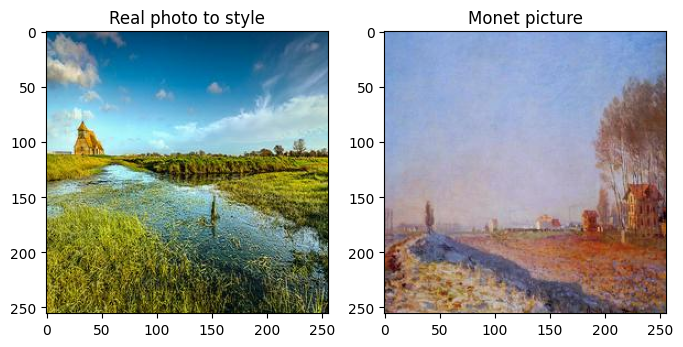

In [9]:
main(photo_img, monet_img)

# Save and Load

In [10]:
def save_state(state, save_path):
    torch.save(state, save_path)

# Model architecture

I will use the CycleGAN model to generate Monet-style photos. Cycled Generative Adversarial Networks (CycleGANs), introduced by Zhu et al. in 2017, facilitate image-to-image translation tasks without requiring paired training examples. They consist of generators and discriminators that work in opposite directions to convert images between domains and distinguish real from generated images. A key feature is the cycle consistency loss, which ensures that an image translated to another domain and back remains close to its original form. This, combined with the adversarial loss that makes generated images indistinguishable from real ones, is crucial for effective training.

CycleGANs enable applications such as artistic style transfer, domain adaptation, and data augmentation. They are particularly beneficial in scenarios where paired training data is scarce, demonstrating qualitative improvements in various tasks like object transfiguration and photo enhancement. This model is an excellent tool for generating Monet-style images.


## Key components (CNN, Generator, Discriminator)

The `GANCycle` class implements a CycleGAN, a type of Generative Adversarial Network for unpaired image-to-image translation tasks, such as transforming a photo into a Monet-like painting and vice versa. It includes two generators (`gen_mtp` and `gen_ptm`) and two discriminators (`desc_m` and `desc_p`) to distinguish real and generated images in both domains. Training involves alternating updates to generators and discriminators, incorporating identity loss, cycle consistency loss, and adversarial loss to enforce the transformations. Key methods handle model initialization, loss computation, and optimization to ensure effective convergence. The utility functions help manage the training process, ensuring stability and efficient learning. Overall, `GANCycle` coordinates the sophisticated training of a CycleGAN model with advanced techniques for optimal results.

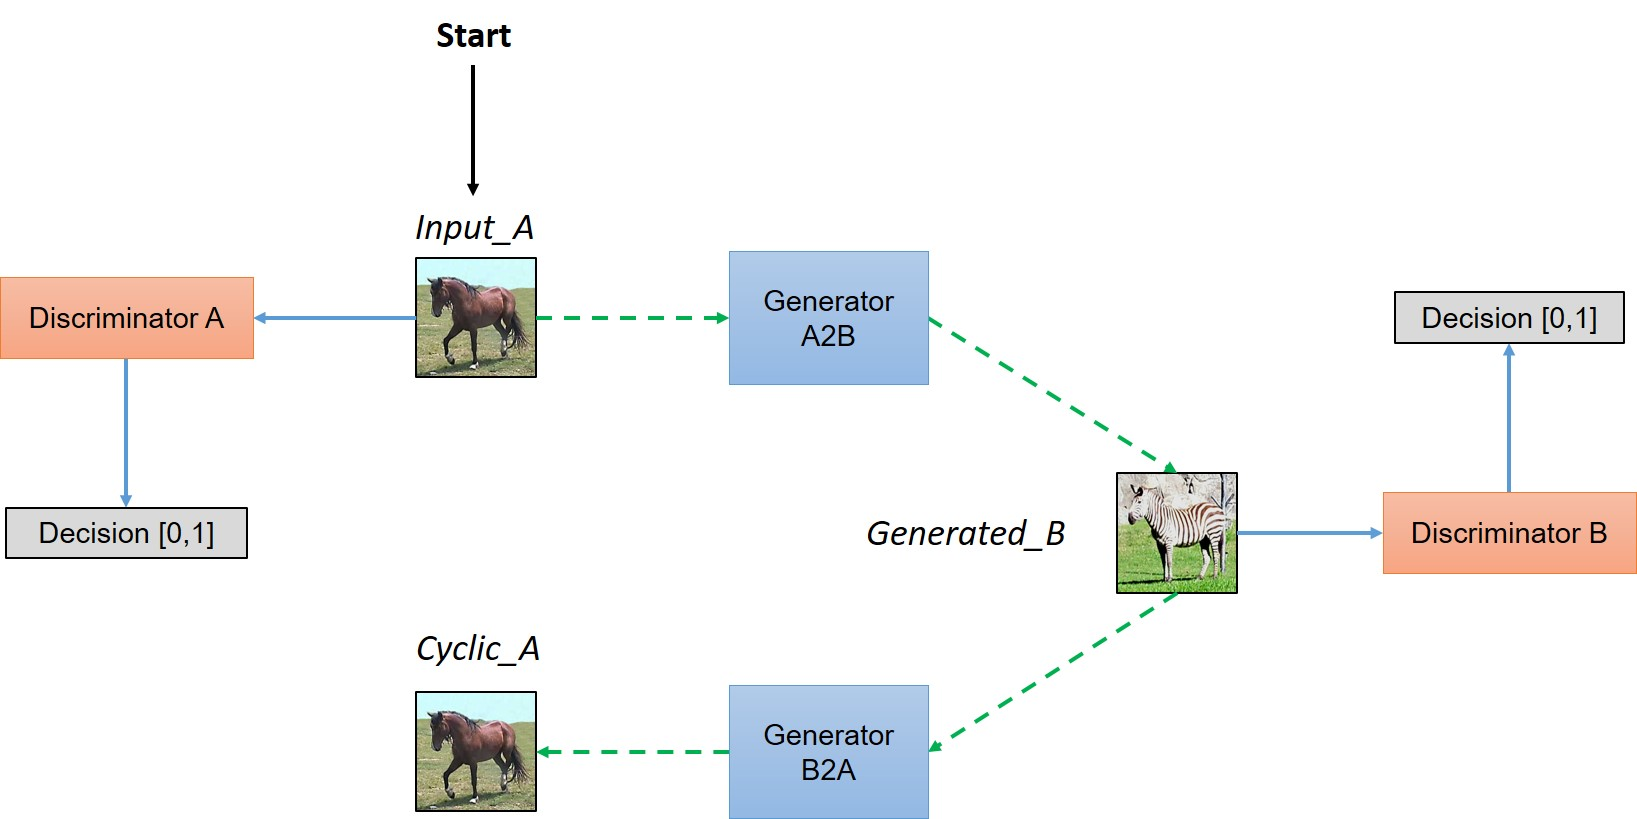

In [35]:
from IPython.display import Image
Image(filename='model.png') 

Source: https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings

In [14]:
class Generator(nn.Module):
    def __init__(self, input_channels, out_channels, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(input_channels, 64, 7, 1, False, True, False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(UpsampleModel(256, 128))
        model.append(UpsampleModel(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_channels, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [15]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, num_layers=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(input_channels, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_layers):
            input_channelss = 64 * 2**(i-1)
            out_channelss = input_channelss * 2
            if i == num_layers -1:
                model.append(Convlayer(input_channelss, out_channelss, 4, 1))
            else:
                model.append(Convlayer(input_channelss, out_channelss, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

In [16]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

## GANCycle

In [21]:
class GANCycle():
    def __init__(self, input_channels, out_channels, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = max(decay_epoch, int(epochs / 2))
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        
        self._initialize_models(input_channels, out_channels)
        self._initialize_loss_functions()
        self._initialize_optimizers(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()), 
                                    itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()), 
                                    start_lr)
        self._initialize_schedulers(self.adam_gen, self.adam_desc, self.decay_epoch, epochs)
        self._initialize_statistics()
        self._initialize_fake_samples()

    def _initialize_models(self, input_channels, out_channels):
        self.gen_mtp = self._init_model(Generator(input_channels, out_channels))
        self.gen_ptm = self._init_model(Generator(input_channels, out_channels))
        self.desc_m = self._init_model(Discriminator(input_channels))
        self.desc_p = self._init_model(Discriminator(input_channels))

    def _init_model(self, model):
        init_weights(model)
        return model.to(self.device)

    def _initialize_loss_functions(self):
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

    def _initialize_optimizers(self, gen_params, desc_params, start_lr):
        self.adam_gen = torch.optim.Adam(gen_params, lr=start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(desc_params, lr=start_lr, betas=(0.5, 0.999))

    def _initialize_schedulers(self, adam_gen, adam_desc, decay_epoch, epochs):
        gen_lr = LRSched(decay_epoch, epochs)
        desc_lr = LRSched(decay_epoch, epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(adam_desc, desc_lr.step)

    def _initialize_statistics(self):
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()

    def _initialize_fake_samples(self):
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss, avg_desc_loss = 0.0, 0.0
            total_samples = len(photo_dl)
            
            t = tqdm(photo_dl, leave=False, total=total_samples)
            for photo_real, monet_real in t:
                photo_img, monet_img = photo_real.to(self.device), monet_real.to(self.device)
                
                self._train_generators(photo_img, monet_img)
                avg_gen_loss += self.total_gen_loss.item()

                self._train_discriminators(photo_img, monet_img)
                avg_desc_loss += self.total_desc_loss.item()
                
                t.set_postfix(gen_loss=self.total_gen_loss.item(), desc_loss=self.total_desc_loss.item())

            self._save_model(epoch)
            self._update_statistics(epoch, avg_gen_loss, avg_desc_loss, total_samples, start_time)

    def _train_generators(self, photo_img, monet_img):
        self._set_requires_grad([self.desc_m, self.desc_p], False)
        self.adam_gen.zero_grad()

        fake_photo, fake_monet = self.gen_mtp(monet_img), self.gen_ptm(photo_img)
        cycl_monet, cycl_photo = self.gen_ptm(fake_photo), self.gen_mtp(fake_monet)
        id_monet, id_photo = self.gen_ptm(monet_img), self.gen_mtp(photo_img)

        idt_loss_monet = self._identity_loss(id_monet, monet_img)
        idt_loss_photo = self._identity_loss(id_photo, photo_img)
        cycle_loss_monet = self._cycle_loss(cycl_monet, monet_img)
        cycle_loss_photo = self._cycle_loss(cycl_photo, photo_img)
        adv_loss_monet = self._adversarial_loss(self.desc_m(fake_monet), True)
        adv_loss_photo = self._adversarial_loss(self.desc_p(fake_photo), True)

        self.total_gen_loss = (idt_loss_monet + idt_loss_photo + cycle_loss_monet + 
                               cycle_loss_photo + adv_loss_monet + adv_loss_photo)

        self.total_gen_loss.backward()
        self.adam_gen.step()

    def _train_discriminators(self, photo_img, monet_img):
        self._set_requires_grad([self.desc_m, self.desc_p], True)
        self.adam_desc.zero_grad()

        with torch.no_grad():
            fake_monet = self._sample_fake(self.gen_ptm(photo_img))
            fake_photo = self._sample_fake(self.gen_mtp(monet_img))

        monet_desc_real = self.desc_m(monet_img)
        monet_desc_fake = self.desc_m(fake_monet)
        photo_desc_real = self.desc_p(photo_img)
        photo_desc_fake = self.desc_p(fake_photo)

        monet_desc_loss = self._discriminator_loss(monet_desc_real, monet_desc_fake)
        photo_desc_loss = self._discriminator_loss(photo_desc_real, photo_desc_fake)

        self.total_desc_loss = monet_desc_loss + photo_desc_loss

        self.total_desc_loss.backward()
        self.adam_desc.step()

    def _identity_loss(self, id_img, target_img):
        return self.l1_loss(id_img, target_img) * self.lmbda * self.idt_coef

    def _cycle_loss(self, cycl_img, target_img):
        return self.l1_loss(cycl_img, target_img) * self.lmbda

    def _adversarial_loss(self, pred, is_real):
        real_target = torch.ones_like(pred).to(self.device) if is_real else torch.zeros_like(pred).to(self.device)
        return self.mse_loss(pred, real_target)

    def _discriminator_loss(self, real_pred, fake_pred):
        real_loss = self.mse_loss(real_pred, torch.ones_like(real_pred).to(self.device))
        fake_loss = self.mse_loss(fake_pred, torch.zeros_like(fake_pred).to(self.device))
        return (real_loss + fake_loss) / 2

    def _sample_fake(self, fake_tensor):
        fake_sample = fake_tensor.cpu().data.numpy()
        fake_sample = torch.tensor(self.sample_monet([fake_sample])[0]).to(self.device)
        return fake_sample

    def _set_requires_grad(self, nets, requires_grad):
        for net in nets:
            for param in net.parameters():
                param.requires_grad = requires_grad

    def _save_model(self, epoch):
        save_dict = {
            'epoch': epoch+1,
            'gen_mtp': self.gen_mtp.state_dict(),
            'gen_ptm': self.gen_ptm.state_dict(),
            'desc_m': self.desc_m.state_dict(),
            'desc_p': self.desc_p.state_dict(),
            'optimizer_gen': self.adam_gen.state_dict(),
            'optimizer_desc': self.adam_desc.state_dict()
        }
        save_state(save_dict, 'model.pt')

    def _update_statistics(self, epoch, avg_gen_loss, avg_desc_loss, total_samples, start_time):
        avg_gen_loss /= total_samples
        avg_desc_loss /= total_samples
        time_req = time.time() - start_time
        
        self.gen_stats.append(avg_gen_loss, time_req)
        self.desc_stats.append(avg_desc_loss, time_req)
        
        print(f"Epoch: {epoch+1} | Generator Loss: {avg_gen_loss:.6f} | Discriminator Loss: {avg_desc_loss:.6f}")
        self.gen_lr_sched.step()
        self.desc_lr_sched.step()

In [36]:
save_state(save_dict, 'init.pt')

In [37]:
gan.train(img_dl)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | Generator Loss: 19.177317 | Discriminator Loss: 4.139967


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 2 | Generator Loss: 14.684225 | Discriminator Loss: 2.180822


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3 | Generator Loss: 11.600112 | Discriminator Loss: 1.093355


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 4 | Generator Loss: 11.106516 | Discriminator Loss: 0.947507


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5 | Generator Loss: 13.566050 | Discriminator Loss: 2.654962


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6 | Generator Loss: 10.174143 | Discriminator Loss: 0.795855


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 7 | Generator Loss: 9.975468 | Discriminator Loss: 0.619985


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 8 | Generator Loss: 9.502929 | Discriminator Loss: 0.564007


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 9 | Generator Loss: 9.323833 | Discriminator Loss: 0.564109


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10 | Generator Loss: 9.049015 | Discriminator Loss: 0.528037


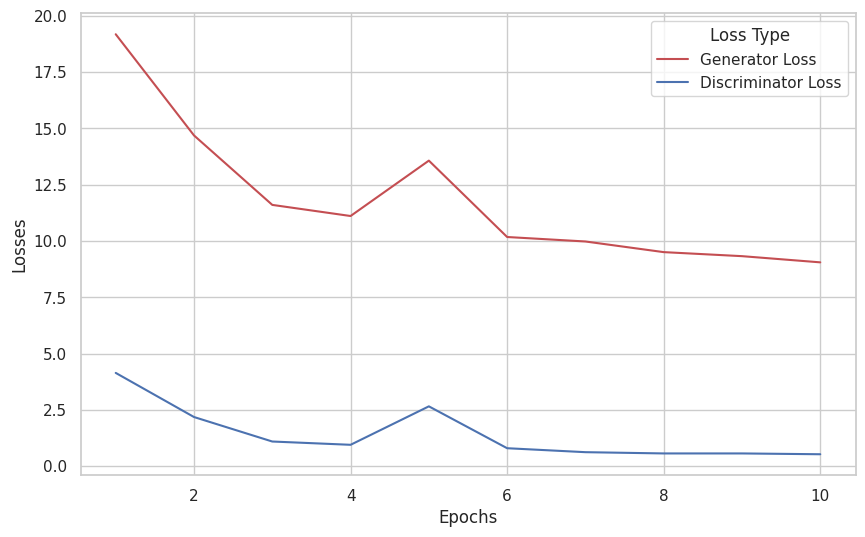

In [38]:
Results:

In [39]:
img_dl = DataLoader(img_ds, batch_size=BATCH_SIZE,num_workers=5, sampler=sampler,drop_last=True)

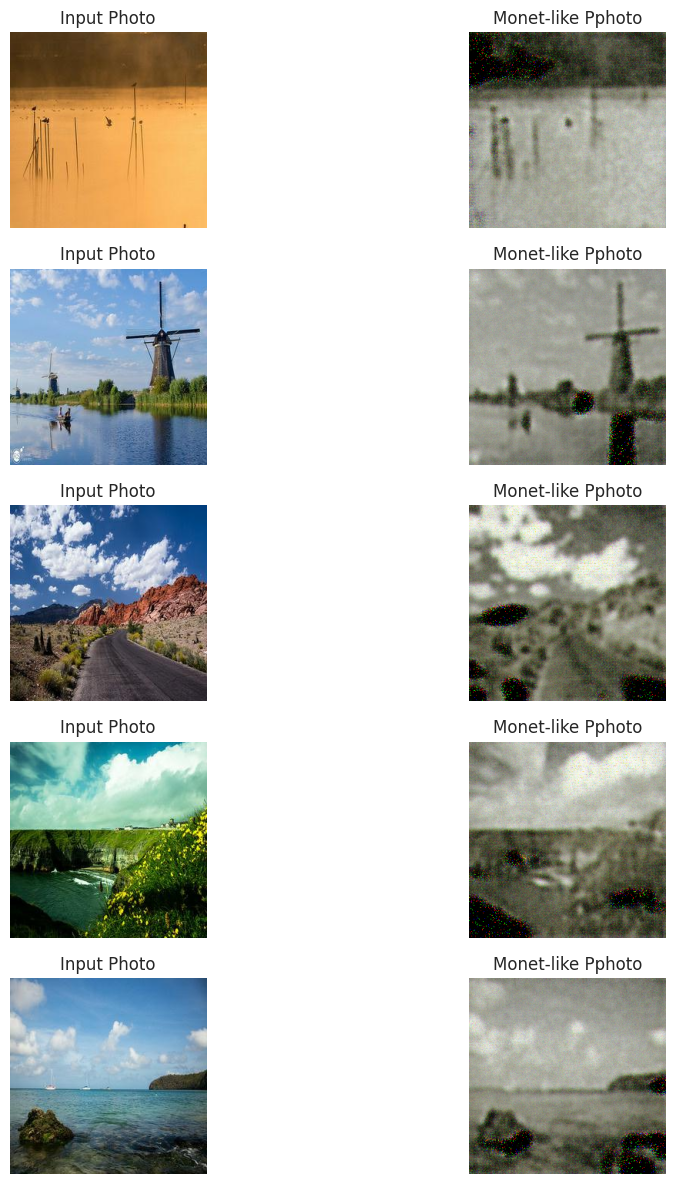

In [45]:
def present_results():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i in range(5):
        photo_img, _ = next(iter(img_dl))
        pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
        photo_img = unnorm(photo_img)
        pred_monet = unnorm(pred_monet)
        
        ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
        ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-like Pphoto")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

present_results()

## More epochs, more colours

I extended the training to 50 epochs, which resulted in a better final distribution. The losses of both the discriminator and the generator continued to decrease. More importantly, the images began to display colors!

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

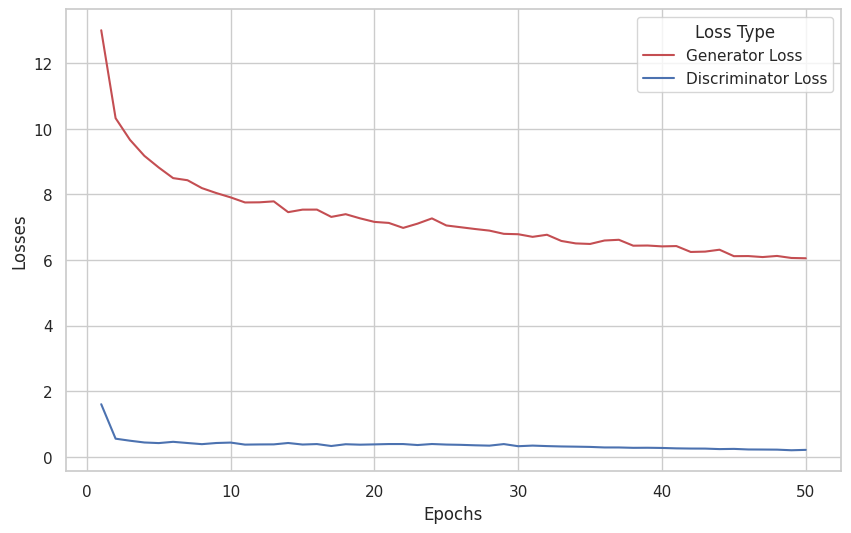

In [26]:
plt.show()

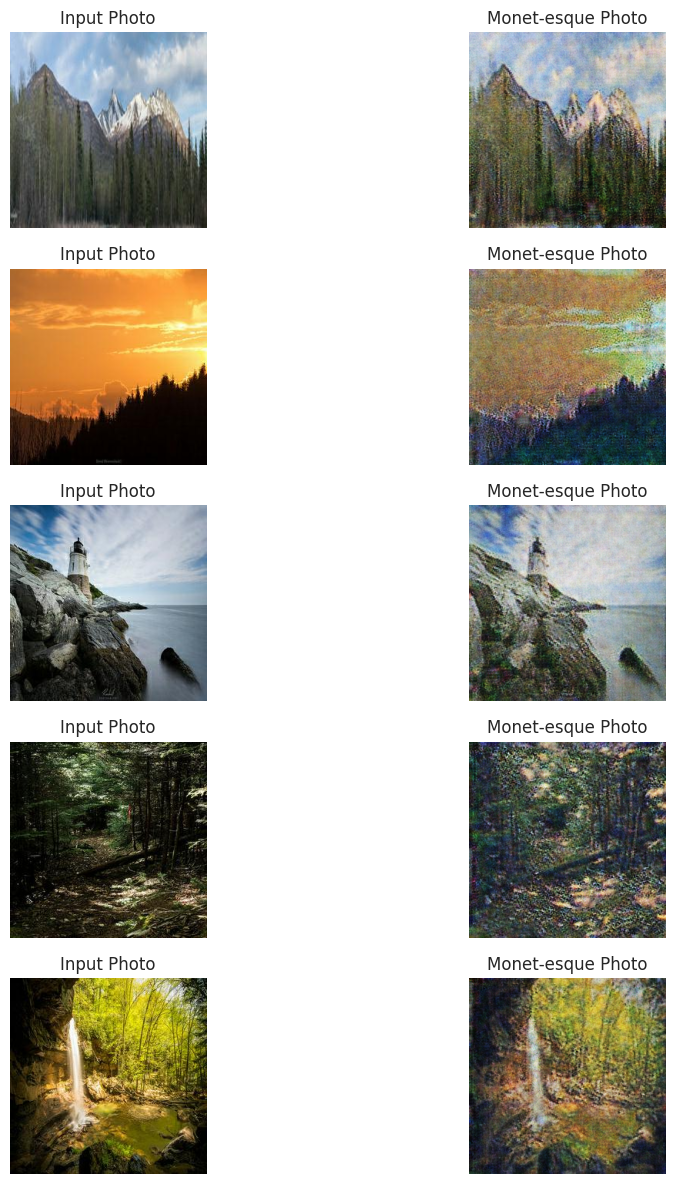

In [28]:
plt.show()

In [42]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img

    def __len__(self):
        return len(self.photo_idx.keys())

ph_ds = PhotoDataset(f'{DATA_PATH}/photo_jpg/')

ph_dl = DataLoader(ph_ds, batch_size=128, pin_memory=True, num_workers=64)


trans = transforms.ToPILImage()

t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
    pred_monet = unnorm(pred_monet)
    img = trans(pred_monet[0]).convert("RGB")
    img.save("images/" + str(i+1) + ".jpg")

shutil.make_archive("images", 'zip', "images")

  0%|          | 0/55 [00:00<?, ?it/s]

'/workspace/gan-monet-boulder/images.zip'

In [43]:
shutil.make_archive("/kaggle/working/images", 'zip', "images")

'/kaggle/working/images.zip'

# Sources
1. https://www.kaggle.com/code/nachiket273/cyclegan-pytorch
2. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
3. https://www.kaggle.com/code/ohseokkim/transfering-style
4. https://junyanz.github.io/CycleGAN/
5. https://en.wikipedia.org/wiki/Claude_Monet
6. https://www.mdpi.com/2076-3417/13/1/635
7. https://link.springer.com/article/10.1007/s42979-021-00884-2
8. https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings